<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/normalityTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.special import logit
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, anderson

%config InlineBackend.figure_format = 'retina'

In [2]:
# Import dependence variable
odr = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv')
odr = odr.query("Segment == 'CU'") #Select only one segment
odr = odr.eval("ODR = Bad / N") #ODR Calculation (12-Motnhs bad rate)

# Dependence variable transformation
# Logit transformation
y = logit(odr['ODR'])

In [3]:
# Import macroeconomics data (Independence variables)
mev = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv')

# Select variables for linear regression model
selectedVars = ['GDP_C_lg12', 'MPI_C_lg12']
X = sm.add_constant(mev[selectedVars]) #Add intercept

In [4]:
# Linear regression model
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ODR   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.68
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           6.99e-15
Time:                        09:56:25   Log-Likelihood:                 100.82
No. Observations:                  59   AIC:                            -195.6
Df Residuals:                      56   BIC:                            -189.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9473      0.019   -155.761      0.0

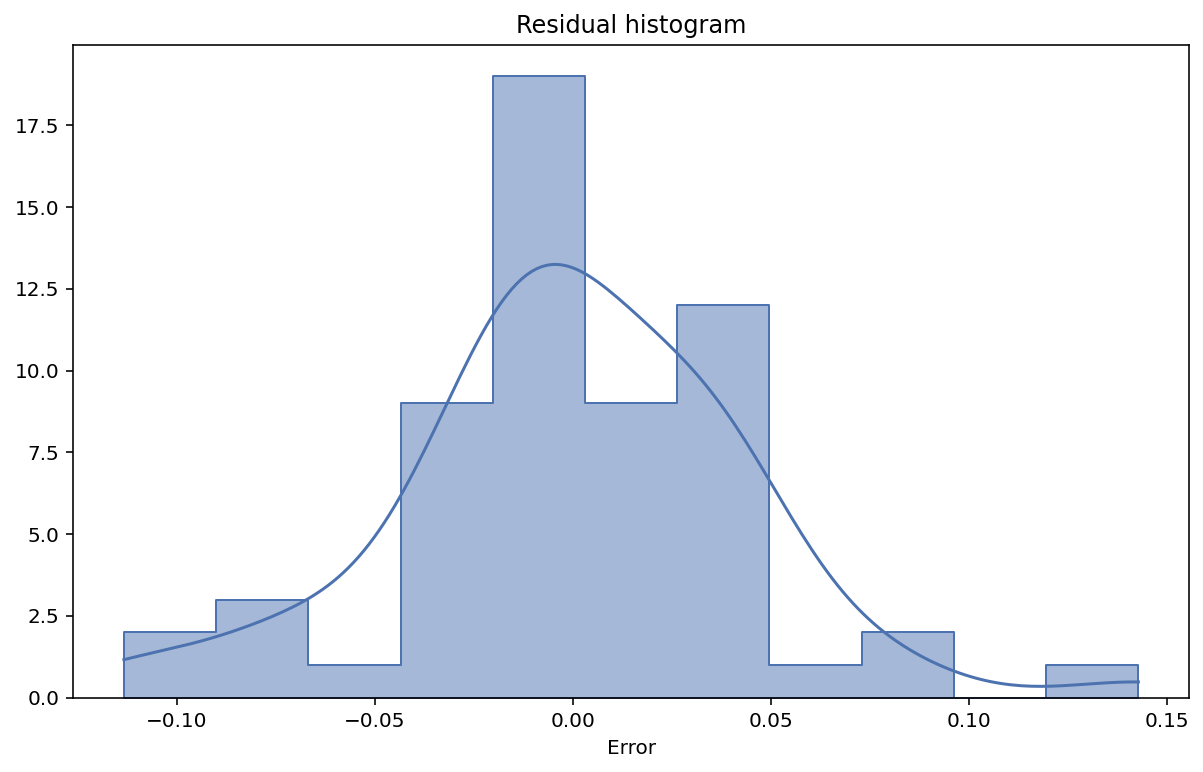

In [5]:
# Plot histogram
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  ax = sns.histplot(x = result.resid,
                    kde = True,
                    element = 'step')
  ax.set_title('Residual histogram')
  ax.set(xlabel = 'Error', ylabel = '')
plt.show()

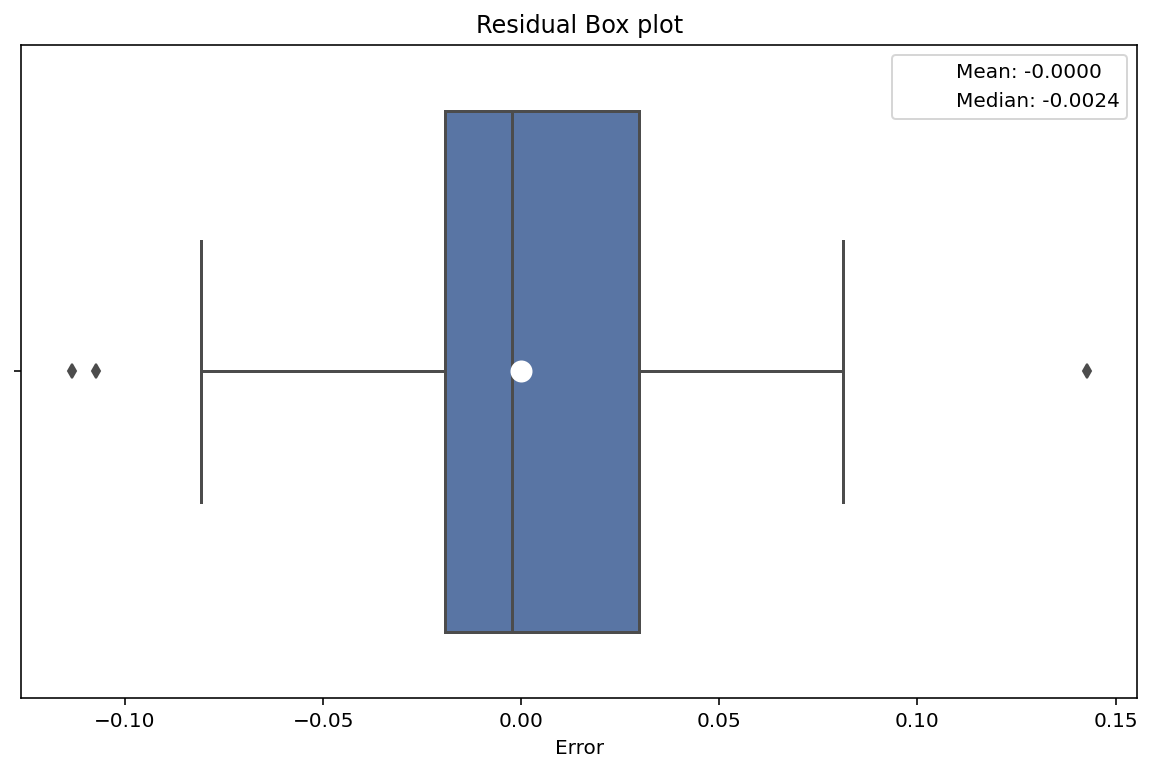

In [6]:
# Box plot
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn-deep'):
  ax = sns.boxplot(x = result.resid,
                   showmeans = True,
                   meanprops = {'marker': 'o',
                                'markerfacecolor': 'white',
                                'markeredgecolor': 'white',
                                'markersize': '10'})
  ax.plot([], [], ' ', label = f'Mean: {np.mean(result.resid):.4f}')
  ax.plot([], [], ' ', label = f'Median: {np.median(result.resid):.4f}')
  ax.legend(frameon = True, facecolor = 'white')
  ax.set_title('Residual Box plot')
  ax.set(xlabel = 'Error', ylabel = '')
plt.show()

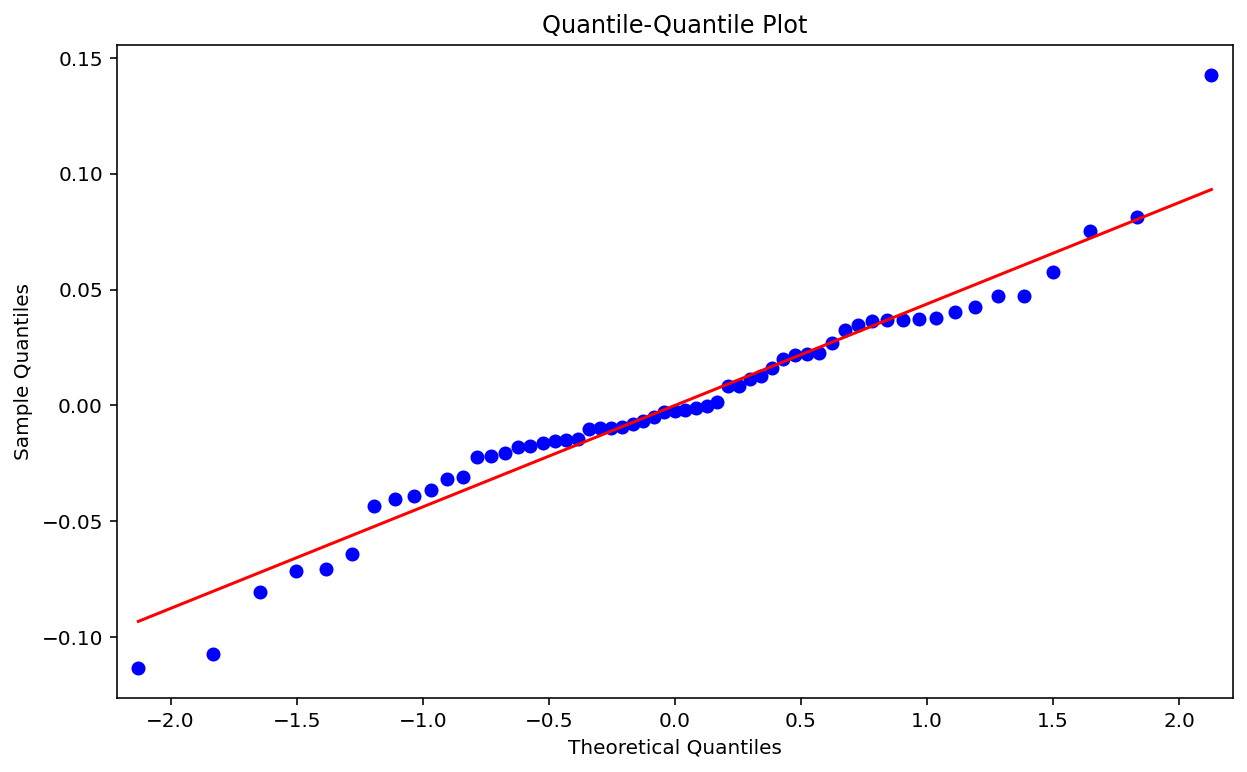

In [7]:
# Quantile-Quantile Plot (Q-Q Plot)
with plt.style.context('seaborn-deep'):
  plt.rc('figure', figsize = (10, 6))
  qqplot(result.resid, line = 's')
  plt.title('Quantile-Quantile Plot')
plt.show()

In [8]:
# Statistic for normality test
# Shapiro-Wilk
shaTest = shapiro(result.resid)
print(f'Shapiro-Wilk statistic: {shaTest[0]:.4f}')
print(f'Shapiro-Wilk p-value: {shaTest[1]:.4f}')

# Result
alpha = 0.05
if shaTest[1] > alpha:
  print('Residual distribution is normal')
else:
  print('Residual distribution is not normal')

Shapiro-Wilk statistic: 0.9680
Shapiro-Wilk p-value: 0.1219
Residual distribution is normal


In [9]:
# Anderson-Darling
andTest = anderson(result.resid)
print(f'Anderson-Darling statistic: {andTest.statistic:.4f}')

# Result by critical values
for i in range(len(andTest.critical_values)):
  if andTest.statistic < andTest.critical_values[i]:
    print(f'Residual distribution is normal at significance level: {andTest.significance_level[i]} with critical values of: {andTest.critical_values[i]}')
  else:
    print(f'Residual distribution is not normal at significance level: {andTest.significance_level[i]} with critical values of: {andTest.critical_values[i]}')

Anderson-Darling statistic: 0.6105
Residual distribution is not normal at significance level: 15.0 with critical values of: 0.543
Residual distribution is normal at significance level: 10.0 with critical values of: 0.619
Residual distribution is normal at significance level: 5.0 with critical values of: 0.742
Residual distribution is normal at significance level: 2.5 with critical values of: 0.866
Residual distribution is normal at significance level: 1.0 with critical values of: 1.03


In [10]:
# Anderson-Darling with p-value
AD, _, _ = anderson(result.resid)
ADAdj = AD * (1 + (.75 / result.resid.shape[0]) + 2.25 / (result.resid.shape[0]**2))
print(f'Anderson-Darling adjustment: {ADAdj:.4f}')

Anderson-Darling adjustment: 0.6186


In [11]:
# Apply with condition
if ADAdj >= 0.6:
  pValue = np.exp(1.2937 - 5.709 * ADAdj + 0.0186 * np.power(ADAdj, 2))
elif ADAdj >= 0.34:
  pValue = np.exp(0.9177 - 4.279 * ADAdj - 1.38 * np.power(ADAdj, 2))
elif ADAdj > 0.2:
  pValue = 1 - np.exp(-8.318 + 42.796 * ADAdj - 59.938 * np.power(ADAdj, 2))
else:
  pValue = 1 - np.exp(-13.436 + 101.14 * ADAdj - 223.73 * np.power(ADAdj, 2))

print(f'Anderson-Darling p-value: {pValue:.4f}')

# Result
alpha = 0.05
if pValue > alpha:
  print('Residual distribution is normal')
else:
  print('Residual distribution is not normal')

Anderson-Darling p-value: 0.1074
Residual distribution is normal
